Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [331]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import os
import PIL
from skimage import io
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import efficientnet.tfkeras as efn
from sklearn.utils import class_weight
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

In [1]:
##If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [12]:
!mkdir "gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment"

In [ ]:
!unzip "gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment.zip" -d "gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment"

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [370]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train_path="gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
data_dir_train = pathlib.Path("gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [28]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [190]:
df_train_file_list = pd.DataFrame({'File_list':list(data_dir_train.glob('*/*.jpg'))})
df_test_file_list = pd.DataFrame({'File_list':list(data_dir_train.glob('*/*.jpg'))})
df_train_file_list['File_list'] = df_train_file_list['File_list'].astype('str')
df_test_file_list['File_list'] = df_test_file_list['File_list'].astype('str')
df_train_file_list['Class'] = df_train_file_list['File_list'].apply(lambda x:x.split("/")[-2])
df_test_file_list['Class'] = df_test_file_list['File_list'].apply(lambda x:x.split("/")[-2])
df_class_weight = pd.DataFrame({'Class':dict(df_train_file_list['Class'].value_counts(normalize=True))})
df_cw = df_class_weight.reset_index()
df_cw1 = df_cw.reset_index()
df_cw2 = df_cw1.rename(columns={'level_0':'class','Class':'weights'})
df_cw2['class'] = df_cw2['class'].astype('int')

In [310]:
df_cw2

,class,index,weights
0,0,actinic keratosis,0.050916
1,1,basal cell carcinoma,0.167932
2,2,dermatofibroma,0.042430
3,3,melanoma,0.195623
4,4,nevus,0.159446
5,5,pigmented benign keratosis,0.206342
6,6,seborrheic keratosis,0.034390
7,7,squamous cell carcinoma,0.080840
8,8,vascular lesion,0.062081


In [278]:
class_weights = list(round(df_cw2['weights'],4))
unique_class_weights = list(df_cw2['class'])

In [277]:
class_weights_dict = { unique_class_weights[i]: w for i,w in enumerate(class_weights) }

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [31]:
batch_size = 32
img_height = 180
img_width = 180

In [29]:
class_names =['Actinic keratosis','Basal cell carcinoma','Dermatofibroma','Melanoma','Nevus','Pigmented benign keratosis','Seborrheic keratosis','Squamous cell carcinoma','Vascular lesion']

Use 80% of the images for training, and 20% for validation.

In [34]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [33]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [37]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [63]:
def img_viz_class_name(data_directory,class_names,class_index):
  img=glob.glob(os.path.join(data_directory, class_names[class_index], '*'))
  plt.imshow(io.imread(img[0]))
  plt.title(class_names[class_index])
  return None

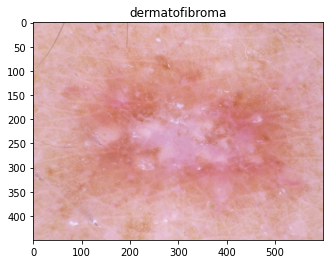

In [65]:
img_viz_class_name(data_dir_train,class_names,2)

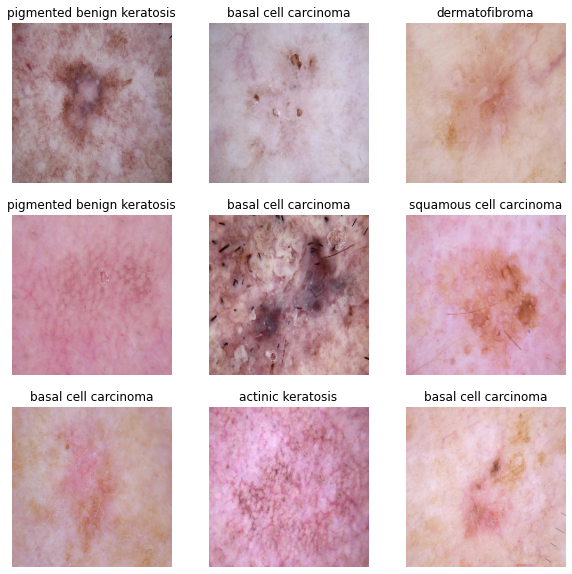

In [162]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [66]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [149]:
### Your code goes here
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),


  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),

  tf.keras.layers.Dense(num_classes)
])

In [151]:
### Todo, choose an appropirate optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
  )

### Train the model

In [153]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 21ms/step - loss: 2.0534 - accuracy: 0.2026 - val_loss: 2.0374 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 1.9443 - accuracy: 0.2528 - val_loss: 1.9011 - val_accuracy: 0.2953
Epoch 3/20
56/56 [==============================] - 1s 18ms/step - loss: 1.8449 - accuracy: 0.3047 - val_loss: 1.7722 - val_accuracy: 0.3199
Epoch 4/20
56/56 [==============================] - 1s 18ms/step - loss: 1.7081 - accuracy: 0.3638 - val_loss: 1.7297 - val_accuracy: 0.3647
Epoch 5/20
56/56 [==============================] - 1s 18ms/step - loss: 1.6635 - accuracy: 0.3867 - val_loss: 1.6505 - val_accuracy: 0.4474
Epoch 6/20
56/56 [==============================] - 1s 18ms/step - loss: 1.5827 - accuracy: 0.4369 - val_loss: 1.6325 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 1s 18ms/step - loss: 1.5117 - accuracy: 0.4660 - val_loss: 1.5836 - val_accuracy: 0.4787
Epoch 8/20
56

In [161]:
# View the summary of all layers
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 41, 41, 32)      

### Visualizing training results

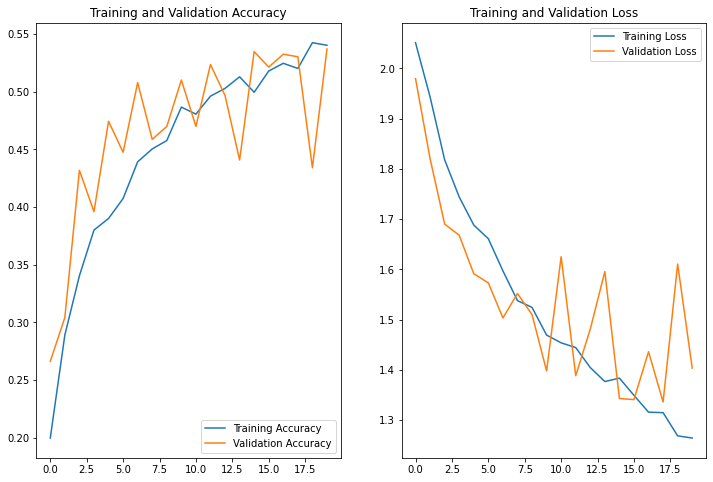

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

* Validation loss is not settle out , it oscillation at end of epochs
* There is diffreence in Train and validation loss 

### Todo:
### Create the model, compile and train the model


In [385]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomZoom(0.75),
  layers.RandomRotation(0.2)
])

### Your code goes here
num_classes = len(class_names)

model_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),


  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),

  tf.keras.layers.Dense(num_classes)
])


### Compiling the model

In [387]:
## Your code goes here

model_augmentation.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
  )

### Training the model

In [390]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_augmentation.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 32s 181ms/step - loss: 2.1972 - accuracy: 0.1055 - val_loss: 2.1972 - val_accuracy: 0.0831
Epoch 2/20
169/169 [==============================] - 31s 181ms/step - loss: 2.1972 - accuracy: 0.1055 - val_loss: 2.1972 - val_accuracy: 0.0831
Epoch 3/20
169/169 [==============================] - 31s 179ms/step - loss: 2.1972 - accuracy: 0.1055 - val_loss: 2.1972 - val_accuracy: 0.0831
Epoch 4/20
169/169 [==============================] - 31s 178ms/step - loss: 2.1972 - accuracy: 0.1055 - val_loss: 2.1972 - val_accuracy: 0.0831
Epoch 5/20
169/169 [==============================] - 31s 177ms/step - loss: 2.1972 - accuracy: 0.1055 - val_loss: 2.1972 - val_accuracy: 0.0831
Epoch 6/20
169/169 [==============================] - 31s 177ms/step - loss: 2.1972 - accuracy: 0.1055 - val_loss: 2.1972 - val_accuracy: 0.0831
Epoch 7/20
169/169 [==============================] - 31s 177ms/step - loss: 2.1972 - accuracy: 0.1055 - val_loss: 2.1972 - val_ac

### Visualizing the results

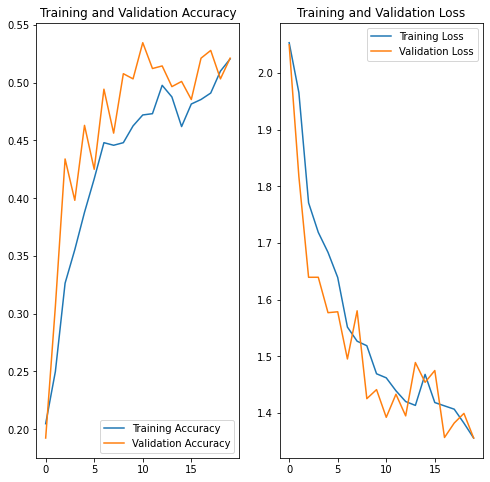

In [177]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [284]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomZoom(0.75),
  layers.RandomRotation(0.2)
])

### Your code goes here
num_classes = len(class_names)

model_augmentation_weight = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),


  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),

  tf.keras.layers.Dense(num_classes)
])


model_augmentation_weight.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
  )

In [285]:
epochs = 20
history = model_augmentation_weight.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs,
    class_weight = class_weights_dict
)

Epoch 1/20
56/56 [==============================] - 3s 25ms/step - loss: 0.2692 - accuracy: 0.1925 - val_loss: 2.0262 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 0.2617 - accuracy: 0.2031 - val_loss: 2.1447 - val_accuracy: 0.2215
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 0.2572 - accuracy: 0.2249 - val_loss: 2.0010 - val_accuracy: 0.2707
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 0.2480 - accuracy: 0.2612 - val_loss: 1.9349 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 0.2316 - accuracy: 0.2919 - val_loss: 2.0433 - val_accuracy: 0.2931
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 0.2279 - accuracy: 0.3136 - val_loss: 1.8368 - val_accuracy: 0.3512
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 0.2085 - accuracy: 0.3616 - val_loss: 1.7706 - val_accuracy: 0.4094
Epoch 8/20
56

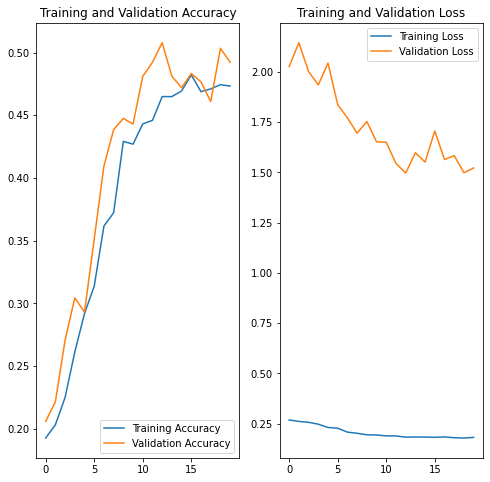

In [286]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Lets try with ResNet50

In [300]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [314]:
model_ResNet50 = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
        data_augmentation,
     tf.keras.applications.ResNet50(
        input_shape=(180,180, 3),
        weights='imagenet',
        include_top=False
    ),
    GlobalAveragePooling2D(),    
    Dense(num_classes, activation='softmax') # num classes = 9
    
])

model_ResNet50.layers[0].trainable = False

model_ResNet50.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [315]:
epochs = 40
history = model_ResNet50.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs,
    callbacks=[lr_scheduler],
    class_weight = class_weights_dict
)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 16s 169ms/step - loss: 0.4486 - accuracy: 0.2533 - val_loss: 583583727616.0000 - val_accuracy: 0.1790 - lr: 0.0100
Epoch 2/40
56/56 [==============================] - 9s 152ms/step - loss: 0.2819 - accuracy: 0.3186 - val_loss: 95.4139 - val_accuracy: 0.1946 - lr: 0.0089
Epoch 3/40
56/56 [==============================] - 9s 153ms/step - loss: 0.2342 - accuracy: 0.3488 - val_loss: 2.1015 - val_accuracy: 0.1924 - lr: 0.0079
Epoch 4/40
56/56 [==============================] - 9s 153ms/step - loss: 0.2138 - accuracy: 0.3733 - val_loss: 2.0986 - val_accuracy: 0.1924 - lr: 0.0071
Epoch 5/40
56/56 [==============================] - 9s 153ms/step - loss: 0.2066 - accuracy: 0.3906 - val_loss: 2.0902 - val_accuracy: 0.1924 - lr: 0.0063
Epoch 6/40
56/56 [==============================] - 9s 153ms/step - loss: 0.2044 - accuracy: 0.3945 - val_loss: 2.0521 - val_accuracy: 0.1924 - lr: 0.0056
Epoch 7/40
56/56 [==============================] - 9s 156ms/step - 

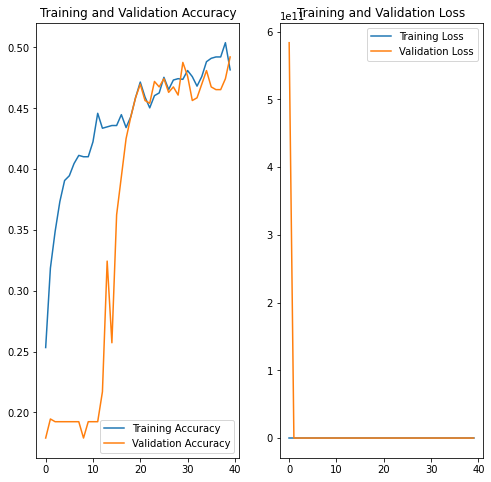

In [317]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

class-"seborrheic keratosis" has less number of samples 
#### - Which classes dominate the data in terms proportionate number of samples?
class-"pigmented benign keratosis" has more number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [318]:
!pip -q install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [326]:
path_to_training_dataset="gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFF05BB3A90>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFF02B9A490>: 100%|██████████| 500/500 [00:18<00:00, 27.65 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFF0722B110>: 100%|██████████| 500/500 [00:19<00:00, 26.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7EFF05C56D90>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFF05BB3210>: 100%|██████████| 500/500 [01:24<00:00,  5.92 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFF05BC9410>: 100%|██████████| 500/500 [00:17<00:00, 27.99 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFF085A9CD0>: 100%|██████████| 500/500 [00:41<00:00, 11.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFF05BC9410>: 100%|██████████| 500/500 [00:18<00:00, 27.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/Colab Notebooks/IIIB-ML-AI/05_Neural_Networks/Intro_NN_Part2_Workbooks/Convolutional-Neural-Networks-main/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFF05A5AF10>: 100%|██████████| 500/500 [00:18<00:00, 26.74 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [327]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [352]:
df_train_file_list = pd.DataFrame({'File_list':list(data_dir_train.glob('*/output/*.jpg'))})

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [373]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [369]:
data_dir_train

'path to directory with training data + data created using augmentor'

In [371]:
#data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [374]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [381]:
## your code goes here

model_ResNet50_more_data = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
        data_augmentation,
     tf.keras.applications.ResNet50(
        input_shape=(180,180, 3),
        weights='imagenet',
        include_top=False
    ),
    GlobalAveragePooling2D(),    
    Dense(num_classes, activation='softmax') # num classes = 9
    
])

model_ResNet50.layers[0].trainable = False

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [382]:
## your code goes here

model_ResNet50_more_data.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

#### **Todo:**  Train your model

In [383]:
epochs = 30
## Your code goes here, use 50 epochs.

history = model_ResNet50_more_data.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs,
    callbacks=[lr_scheduler],
    class_weight = class_weights_dict
)



Epoch 1/30
169/169 [==============================] - 45s 225ms/step - loss: 0.3291 - accuracy: 0.1940 - val_loss: 2.2889 - val_accuracy: 0.1403 - lr: 0.0100
Epoch 2/30
169/169 [==============================] - 38s 217ms/step - loss: 0.2067 - accuracy: 0.2598 - val_loss: 2.3820 - val_accuracy: 0.1403 - lr: 0.0089
Epoch 3/30
169/169 [==============================] - 38s 219ms/step - loss: 0.1994 - accuracy: 0.2769 - val_loss: 2.6546 - val_accuracy: 0.1403 - lr: 0.0079
Epoch 4/30
169/169 [==============================] - 38s 218ms/step - loss: 0.1982 - accuracy: 0.2691 - val_loss: 2.6099 - val_accuracy: 0.1411 - lr: 0.0071
Epoch 5/30
169/169 [==============================] - 38s 217ms/step - loss: 0.1929 - accuracy: 0.2832 - val_loss: 2.3778 - val_accuracy: 0.1670 - lr: 0.0063
Epoch 6/30
169/169 [==============================] - 37s 216ms/step - loss: 0.1953 - accuracy: 0.2819 - val_loss: 2.2769 - val_accuracy: 0.2175 - lr: 0.0056
Epoch 7/30
169/169 [==============================] 

#### **Todo:**  Visualize the model results

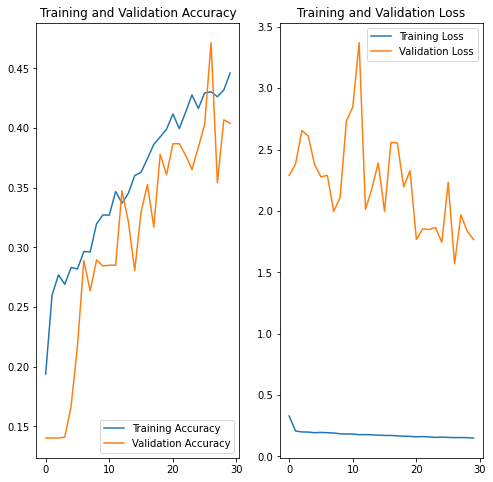

In [384]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



* Yes , Oversampling help to reduce the class imbalance